In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns


In [2]:
import sys
sys.path.append("../functions/")
#for data preprocessing
import Scripts_Data_Processing
import imp

imp.reload(Scripts_Data_Processing)
from Scripts_Data_Processing import *
#for model fit
import Scripts_LogRegModels_v2
imp.reload(Scripts_LogRegModels_v2)
from Scripts_LogRegModels_v2 import *

import NoBrainer_Analysis_AllinOne
imp.reload( NoBrainer_Analysis_AllinOne)
from  NoBrainer_Analysis_AllinOne import *

In [20]:
model_param_df

,MID,parameter,split,beta
1,vp06,intercept,ambig_shock,-0.797270
2,vp06,mag_diff_gain,ambig_shock,-0.598574
3,vp06,prob_diff_gain,ambig_shock,-1.654646
4,vp06,sqrt_prop_revealed_gain,ambig_shock,-0.279013
5,vp06,intercept,unambig_shock,0.456900
6,vp06,mag_diff_gain,unambig_shock,-1.402098
7,vp06,prob_diff_gain,unambig_shock,-2.387074
8,vp07,intercept,ambig_shock,-1.150478
9,vp07,mag_diff_gain,ambig_shock,-0.548955
10,vp07,prob_diff_gain,ambig_shock,-1.871591


In [3]:
# first version of the function without bars being split
def plot_params(df,stripplot=False,outlier_cutoff=None,task='shock'):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context('talk')
    sns.set_style('white',{'figure.facecolor':'white'})
    
    
    if outlier_cutoff is not None:
        df = df[(df.beta>-1.0*outlier_cutoff)&(df.beta<outlier_cutoff)]
    
    axis = sns.barplot(x='parameter',y='beta',data=df,color=[.4,.4,.4],ci=95,alpha=0.4)
    
    if stripplot:
        sns.stripplot(x="parameter", y="beta", data=df,color=[.4,.4,.4],alpha=0.2,jitter=True);

        
    current_palette=sns.color_palette()
    fig = plt.gcf()
    fig.suptitle('Model Parameters: '+modelname+' '+task,fontsize=12,x=0.55)
    sns.despine(ax=axis)
    axis.set_ylabel('beta (Prob Choose Right (except on Ambig))',fontsize=12)
    axis.set_xlabel('parameter',fontsize=12)
    axis.set_xticklabels(df.parameter.unique(),rotation=45,fontsize=12,ha='right')
    axis = plt.gca()
    
    # change name if needed
    xlabels = axis.get_xticklabels()

    fig.suptitle('')
    axis.set_title('Model Parameters (Across all Subjects)')
    axis.set_xlabel('Parameter')
    axis.set_ylabel('Group Regression Coefficients \n (Probability Choosing Ambig)')
    plt.tight_layout()
    return(fig)

In [29]:
# second version of the function with bar graphs being split
def plot_params(df,stripplot=False,outlier_cutoff=None):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context('talk')
    sns.set_style('white',{'figure.facecolor':'white'})
    
    
    if outlier_cutoff is not None:
        df = df[(df.beta>-1.0*outlier_cutoff)&(df.beta<outlier_cutoff)]
    
    axis = sns.barplot(x='parameter',y='beta',hue='split',data=df,ci=95,alpha=0.4)
    
    if stripplot:
        sns.stripplot(x="parameter", y="beta",hue='split', data=df,alpha=0.2,jitter=True);

    current_palette=sns.color_palette()
    fig = plt.gcf()
    fig.suptitle('Model Parameters:',fontsize=12,x=0.55)
    sns.despine(ax=axis)
    axis.set_ylabel('beta (Prob Choose Right (except on Ambig))',fontsize=12)
    axis.set_xlabel('parameter',fontsize=12)
    axis.set_xticklabels(df.parameter.unique(),rotation=45,fontsize=12,ha='right')
    axis = plt.gca()
    
    # change name if needed
    #xlabels = axis.get_xticklabels()

    #fig.suptitle('')
    #axis.set_title('Model Parameters (Across all Subjects)')
    #axis.set_xlabel('Parameter')
    #axis.set_ylabel('Group Regression Coefficients \n (Probability Choosing Ambig)')
    #plt.tight_layout()
    return(fig)

# gainloss load in single subjectdata + nobrainer

In [21]:
df_list = []
vp_perform_gainloss_list = []
vp_nb_gainloss_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22'] #'23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
for vp in vp_list:
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_gainloss(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_gainloss = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_gainloss_list.append(vp_perform_gainloss)
    #vp performance sectionwise
    vp_nb_gainloss = nb_df.groupby('section').mean().add_prefix('gainloss_')[['gainloss_choseBetter']]
    vp_nb_gainloss['MID'] = 'vp'+ vp
    vp_nb_gainloss_list.append(vp_nb_gainloss)
    
#make dataframe for nb performance
nobrainer_gainloss = pd.DataFrame(vp_perform_gainloss_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
gainloss_ls_df = df


In [5]:
vp_nb_gainloss_list

[         gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp06
 2                    1.000000  vp06
 3                    0.928571  vp06,          gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp07
 2                    1.000000  vp07
 3                    1.000000  vp07,          gainloss_choseBetter   MID
 section                            
 1                         1.0  vp10
 2                         1.0  vp10
 3                         1.0  vp10,          gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp11
 2                    1.000000  vp11
 3                    1.000000  vp11,          gainloss_choseBetter   MID
 section                            
 1                    1.000000  vp12
 2                    0.909091  vp12
 3                    0.928571  vp12,          gainloss_choseBetter   MID
 section                            
 

## Create preprocessed dataframe with all vp

In [6]:
#Merge dataframe list to single dataframe. "inner": Just take columns which exist in all dataframes    
gainloss_df = pd.concat(df_list, ignore_index = True, join = 'inner')  

## Gain/Loss Model fit - individual subjects

In [7]:
param_sets_split = {}
param_sets_split['0'] = ['mag_diff','prob_diff']
param_sets_split['1'] = ['mag_diff','prob_diff','sqrt_prop_revealed']

In [22]:
vp_list = ['06','07','10', '12', '13', '15', '16', '17', '18', '19', '20', '22'] #'23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc']
model_param_df = np.array(['','','',3.0])
model_summary_df = nobrainer_gainloss

for vp in vp_list:
    
    df = gainloss_df[gainloss_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_gain','ambig_loss','unambig_gain','unambig_loss']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=False)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        for param in params.index:
            paramn = param.replace('_loss','')
            paramn = paramn.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')

print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()

73.2149550654
0.791666666667
model_split_unambig_lossmag_diff_prob_diff


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                  0.2771
Time:                        16:37:55   Log-Likelihood:                -33.607
converged:                       True   LL-Null:                       -46.491
                                        LLR p-value:                 2.539e-06
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
intercept             0.5567      0.303      1.835      0.067        -0.038     1.152
mag_diff_rl_loss      0.0289      0.012      2.344      0.019         0.005     0.053
prob_diff_rl_loss    -7.1660      1.853     -3.868      0.000       -10.797    -3.535
=====================================================================================
"""

In [9]:
## Plot gain loss data

C:\Users\Hanna\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


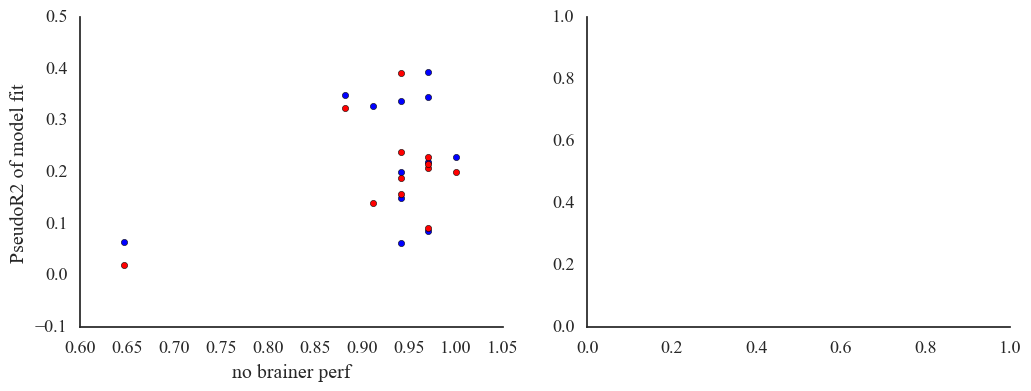

In [10]:

plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(model_summary_df.nbperf,model_summary_df.pseudoR2_ambig_gain,label='gain trials', c='b')
axes[0].scatter(model_summary_df.nbperf,model_summary_df.pseudoR2_ambig_loss,label='loss trials', c='r')
sns.despine()
axes[0].set_xlabel('no brainer perf')
axes[0].set_ylabel('PseudoR2 of model fit')
plt.legend()


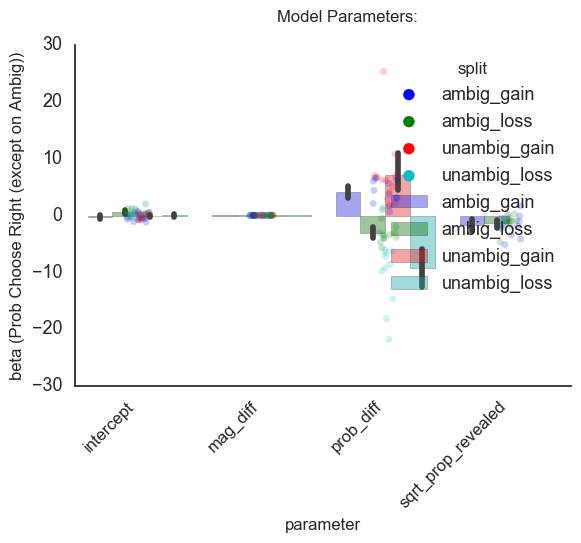

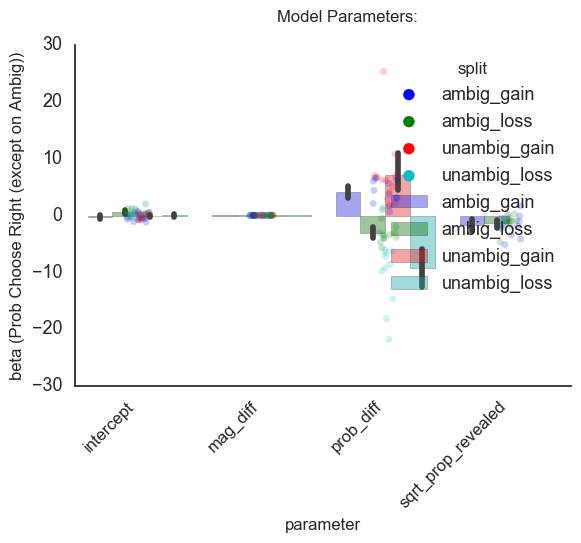

In [30]:
plot_params(model_param_df, stripplot=True)

In [25]:
model_param_df

,MID,parameter,split,beta
1,vp06,intercept,ambig_gain,-0.761985
2,vp06,mag_diff,ambig_gain,0.012441
3,vp06,prob_diff,ambig_gain,1.669512
4,vp06,sqrt_prop_revealed,ambig_gain,-1.877960
5,vp06,intercept,ambig_loss,-0.064936
6,vp06,mag_diff,ambig_loss,0.043434
7,vp06,prob_diff,ambig_loss,-0.463832
8,vp06,sqrt_prop_revealed,ambig_loss,0.291617
9,vp06,intercept,unambig_gain,0.195470
10,vp06,mag_diff,unambig_gain,0.022708


In [12]:
## ask Chris about llr_pvalue
axes[1].scatter(model_summary_df.nbperf,model_summary_df.llr_pvalue_ambig_gain,label='gain trials')
axes[1].scatter(model_summary_df.nbperf,model_summary_df.llr_pvalue_ambig_loss,label='loss trials')
sns.despine()
axes[1].set_xlabel('no brainer perf')
axes[1].set_ylabel('p-value of model fit')
plt.legend()
axes[1].axhline(y=0.05,linestyle='--',color='k')

AttributeError: 'DataFrame' object has no attribute 'llr_pvalue_ambig_gain'

# Fit group of gain loss data
redundant to what I did before?

In [ ]:
for vp in vp_list:
    
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)

    for split in ['ambig_shock','ambig_gain','ambig_loss']:
        out = fit_model_split_amb_unamb_gain_loss(trial_table,
                                                  whichreturn=split,
                                                  params=param_sets_split['1'],zscore=False)
        modelname = out['modelname']
        print(modelname)
        print(out['params'])
        #pickle.dump(out,open(savefolder+
                #MID+'_'+modelname+'.p', "wb" ))

# shock load in single subjectdata + nobrainer

In [13]:
df_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
vp_perform_shock_list = []
vp_nb_shock_list = []
section_list = ['1', '2', '3']
for vp in vp_list:
    df = []
    for sec in section_list:
        path = os.path.join(os.getcwd(),'..','data','data_shock_logfiles','Expt1Pain_Behaviour_vp' + vp + '_' + sec + '.txt')
        df_dummy = pd.read_csv(path, sep="\t", skiprows = [0])
        df_dummy = df_dummy[:-1] #deletes last row of each section as it does not contain trial data
        df_dummy['MID'] = 'vp'+ vp
        df_dummy['section'] = sec
        df_dummy.columns = df_dummy.columns.str.replace(' ','')
        df.append(df_dummy)
    
    #create a df that contains data from all sections    
    df = pd.concat(df, ignore_index = True, join = 'inner')
    #preprocess shock data
    df = preprocess_shock(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_shock(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_shock = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_shock_list.append(vp_perform_shock)
    #vp performance sectionwise
    vp_nb_shock = nb_df.groupby('section').mean().add_prefix('shock_')[['shock_choseBetter']]
    vp_nb_shock['MID'] = 'vp'+ vp
    vp_nb_shock_list.append(vp_nb_shock)
    
#make dataframe for nb performance
nobrainer_shock = pd.DataFrame(vp_perform_shock_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
shock_ls_df = df

../functions/NoBrainer_Analysis_AllinOne.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=lb
../functions/NoBrainer_Analysis_AllinOne.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=rb


In [14]:
vp_nb_shock_list

[         shock_choseBetter   MID
 section                         
 1                      1.0  vp06
 2                      1.0  vp06
 3                      0.6  vp06,          shock_choseBetter   MID
 section                         
 1                      1.0  vp07
 2                      1.0  vp07
 3                      1.0  vp07,          shock_choseBetter   MID
 section                         
 1                      1.0  vp10
 2                      1.0  vp10
 3                      1.0  vp10,          shock_choseBetter   MID
 section                         
 1                      1.0  vp11
 2                      1.0  vp11
 3                      1.0  vp11,          shock_choseBetter   MID
 section                         
 1                      0.8  vp12
 2                      1.0  vp12
 3                      1.0  vp12,          shock_choseBetter   MID
 section                         
 1                      1.0  vp13
 2                      1.0  vp13
 3            

## Create preprocessed dataframe with all vp

In [15]:
#create complete df for shock condition with all vps        
shock_df = pd.concat(df_list, ignore_index = True, join = 'inner')

## Shock: Model fit


In [16]:
#out

In [17]:
vp_list = ['06', '07', '10', '11' ,'12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc'] ##'llr_pvalue' is missing bc did not work
model_param_df = np.array(['','','',3.0])
model_summary_df = nobrainer_shock

for vp in vp_list:
    
    df = shock_df[shock_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_shock','unambig_shock']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        for param in params.index:
            paramn = param.replace('_shock','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')

print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()
    
        
   

83.7804639334
0.722222222222
model_split_unambig_shockmag_diff_prob_diff


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                  0.2137
Time:                        16:26:19   Log-Likelihood:                -38.890
converged:                       True   LL-Null:                       -49.461
                                        LLR p-value:                 2.565e-05
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
intercept             0.3258      0.279      1.166      0.244        -0.222     0.874
mag_diff_rl_gain     -1.8564      0.535     -3.471      0.001        -2.905    -0.808
prob_diff_rl_gain    -1.6386      0.485     -3.376      0.001        -2.590    -0.687
=====================================================================================
"""

## Plot shock data

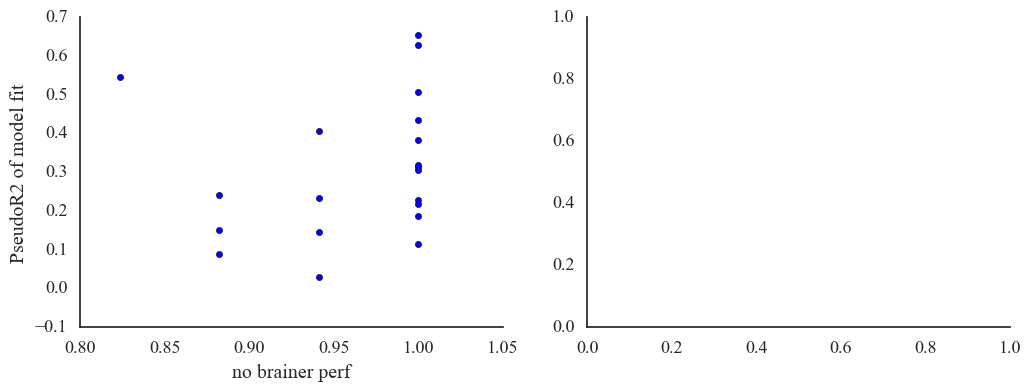

In [18]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(model_summary_df.nbperf,model_summary_df.pseudoR2_ambig_shock,label='shock trials', c='b')
sns.despine()
axes[0].set_xlabel('no brainer perf')
axes[0].set_ylabel('PseudoR2 of model fit')
plt.legend()

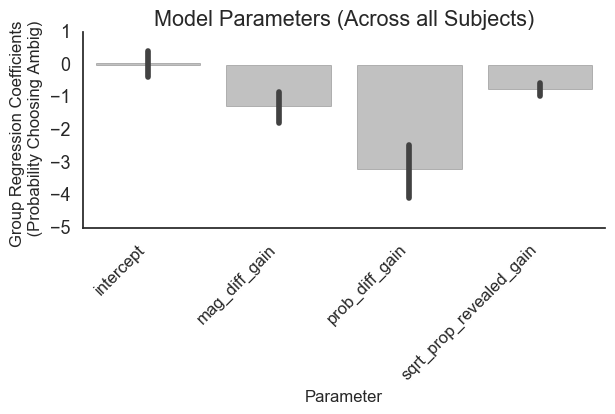

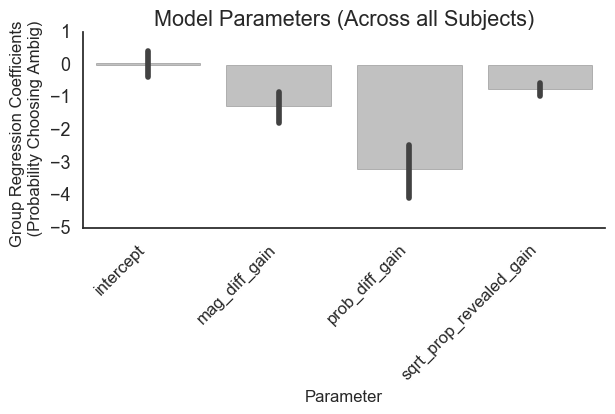

In [19]:
plot_params(model_param_df)

# Load subject fits and Plot Coefficients

See Example_analyze_emmas_fmri_shock_data

In [ ]:
nobrainer_shock

In [ ]:
nobrainer_gainloss

In [ ]:
vp_nb_gainloss_list